Import necessary libraries and modules.

# Walmart Sales Forecasting: Business Objectives

**Objective:**
- Accurately forecast weekly sales for Walmart stores and departments using historical data and store-level features.

**Business Goals:**
- Improve inventory management and reduce stockouts or overstock situations.
- Optimize promotional strategies and holiday planning based on sales trends.
- Support financial planning and resource allocation for stores and departments.
- Identify key drivers of sales to inform business decisions.

**Success Criteria:**
- Achieve high predictive accuracy (e.g., R² > 0.9) on unseen data.
- Provide actionable insights for store managers and business analysts.
- Enable scenario analysis for holidays, promotions, and store types.

In [114]:
import os
import kagglehub

import numpy as np      # To use np.arrays
import pandas as pd     # To use dataframes

# To plot
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
import seaborn as sns

# Feature Engineering
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

#Remove or hide warnings
import warnings
warnings.filterwarnings("ignore")

### 1. Load Data
You can download the dataset from here: https://www.kaggle.com/datasets/aslanahmedov/walmart-sales-forecast or use the Kagglehub api like in the below cell.

In [2]:
# Download latest version
path = kagglehub.dataset_download("aslanahmedov/walmart-sales-forecast")

print("Path to dataset files:", path)

100%|██████████| 3.36M/3.36M [00:00<00:00, 8.55MB/s]

Extracting files...


Path to dataset files: /Users/vinaldsouza/.cache/kagglehub/datasets/aslanahmedov/walmart-sales-forecast/versions/1


In [5]:
# List files in the downloaded dataset directory
print("Files in dataset folder:", os.listdir(path))

Files in dataset folder: ['test.csv', 'train.csv', 'features.csv', 'stores.csv']


### 2. Dataset Overview
We have four datasets:
- **train.csv**: Weekly sales by `Store`, `Dept`, `Date`, with `Weekly_Sales` and `IsHoliday`.
- **test.csv**: Same columns as train.csv except `Weekly_Sales` (to predict).
- **features.csv**: Store-level features such as `Temperature`, `Fuel_Price`, `MarkDown1–5`, `CPI`, `Unemployment`, and `IsHoliday`.
- **stores.csv**: Metadata including `Store` type (A/B/C) and `Size`.

**Sample Columns:**
- Store identifiers (`Store`, `Dept`)
- Dates (weekly)
- Boolean holiday indicator
- Macroeconomic indicators (CPI, Unemployment)
- Promotional markdown amounts

In [7]:
# Show the structure of each file in the dataset folder
for filename in os.listdir(path):
    file_path = os.path.join(path, filename)
    if filename.endswith('.csv'):
        print(f'---{filename} ---')
        df = pd.read_csv(file_path)
        print(df.info())
        print(df.head())
    else:
        print(f'{filename} is not a CSV file, skipping.')

---test.csv ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115064 entries, 0 to 115063
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Store      115064 non-null  int64 
 1   Dept       115064 non-null  int64 
 2   Date       115064 non-null  object
 3   IsHoliday  115064 non-null  bool  
dtypes: bool(1), int64(2), object(1)
memory usage: 2.7+ MB
None
   Store  Dept        Date  IsHoliday
0      1     1  2012-11-02      False
1      1     1  2012-11-09      False
2      1     1  2012-11-16      False
3      1     1  2012-11-23       True
4      1     1  2012-11-30      False
---train.csv ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  obj

In [11]:
df_store = pd.read_csv(path + "/stores.csv")
df_store.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [12]:
df_train = pd.read_csv(path + "/train.csv")
df_train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [13]:
df_features = pd.read_csv(path + "/features.csv")
df_features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [14]:
df_test = pd.read_csv(path + "/test.csv")
df_test.head()

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False


### Merge datasets

The features.csv file contains additional attributes for each store, while weekly sales data is available in the train and test datasets, and store metadata (store and department information) is provided in the stores dataset. We will set aside the test dataset for future evaluation and merge the train, stores, and features dataframes to create a consolidated dataset for analysis.

Inner join is used to avoid any records that are unmatched.

In [17]:
#Merge Features with Train and Test Data
df = pd.merge(df_train, df_features, on=["Store", "Date"], how="inner").merge(df_store, on=["Store"], how="inner")
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature_x,Fuel_Price_x,MarkDown1_x,MarkDown2_x,MarkDown3_x,...,MarkDown1_y,MarkDown2_y,MarkDown3_y,MarkDown4_y,MarkDown5_y,CPI_y,Unemployment_y,IsHoliday,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False,A,151315


In [24]:
df.drop(['IsHoliday_x'], axis=1,inplace=True) # removing dublicated isHoliday column from merged df

In [25]:
df.head()

,Store,Dept,Date,Weekly_Sales,Temperature_x,Fuel_Price_x,MarkDown1_x,MarkDown2_x,MarkDown3_x,MarkDown4_x,...,MarkDown1_y,MarkDown2_y,MarkDown3_y,MarkDown4_y,MarkDown5_y,CPI_y,Unemployment_y,IsHoliday,Type,Size
0,1,1,2010-02-05,24924.50,42.31,2.572,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
1,1,1,2010-02-12,46039.49,38.51,2.548,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True,A,151315
2,1,1,2010-02-19,41595.55,39.93,2.514,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False,A,151315
3,1,1,2010-02-26,19403.54,46.63,2.561,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False,A,151315
4,1,1,2010-03-05,21827.90,46.50,2.625,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False,A,151315


In [26]:
df.shape

(421570, 25)

### 3. Data Exploration
#### Department and Store Analysis

In [31]:
print(df['Store'].nunique()) # number of different values
print(df['Dept'].nunique()) # number of different values

45
81


There are 45 unique stores and 81 different departments. Now lets create a pivot table that shows the mean weekly sales for given (store, dept) combination.

In [32]:
store_dept_table = pd.pivot_table(df, index='Store', columns='Dept',
                                  values='Weekly_Sales', aggfunc=np.mean)
display(store_dept_table)

Dept,1,2,3,4,5,6,7,8,9,10,...,90,91,92,93,94,95,96,97,98,99
Store,,,,,,,,,,,,,,,,,,,,,
1,22513.322937,46102.090420,13150.478042,36964.154476,24257.941119,4801.780140,24566.487413,35718.257622,28062.052238,31033.386364,...,82427.547832,64238.943427,135458.969510,71699.182378,63180.568182,120772.062168,33251.831639,35207.348811,11827.770769,306.091081
2,30777.980769,65912.922517,17476.563357,45607.666573,30555.315315,6808.382517,40477.837063,58707.369441,34375.864476,38845.854476,...,97611.537133,80610.380350,164840.230979,70581.977063,70018.672517,143588.751888,34319.063846,40697.204056,14035.400839,475.896905
3,7328.621049,16841.775664,5509.300769,8434.186503,11695.366573,2012.411818,10044.341608,8310.254196,9062.007692,10871.944126,...,1540.049161,318.685594,7568.280210,NaN,656.294444,15745.528252,3934.540000,343.437357,30.570833,NaN
4,36979.940070,93639.315385,19012.491678,56603.400140,45668.406783,8241.777692,50728.151399,62949.723776,34437.170979,37269.667413,...,89248.965524,66535.407203,159365.107902,67815.163007,68159.106573,147236.473706,38346.573077,39339.238951,15009.249371,623.182381
5,9774.553077,12317.953287,4101.085175,9860.806783,6699.202238,1191.057622,6124.484336,13735.709441,7919.805944,9783.395385,...,3059.520000,1457.221678,7759.205594,NaN,411.431486,19340.693986,5985.671119,667.070315,29.976087,NaN
6,23867.553776,50269.437273,16806.638811,34187.366503,34465.307622,7225.566643,34526.870420,47577.719790,48271.060140,47436.477902,...,53715.366084,45270.405175,99024.796503,41359.651189,41701.693497,89208.786294,30450.542238,20637.667063,9728.100629,388.636750
7,9542.801259,22603.690769,8633.536923,14950.518601,13860.350490,6329.928811,10925.757063,13970.619371,29722.736084,21136.560280,...,13858.405874,10263.880000,26530.890559,1328.178252,699.332522,34208.097273,1123.383217,4374.927902,260.886596,15.000000
8,14789.827343,35729.821748,10683.305105,21089.309301,19838.849231,3395.425455,20268.743776,26438.524336,11792.661678,20666.433776,...,39333.566154,31530.560909,60465.630000,27515.635315,25442.578042,62951.463706,16.986667,16978.366503,6880.466434,298.153714
9,11846.558252,24969.477413,7497.356783,17165.947762,19282.746014,2806.416364,13826.694336,21424.470699,13196.569720,12810.480350,...,2981.249510,869.273287,14123.063147,21.240000,599.112568,29575.050769,3596.107762,372.655556,27.930000,NaN


In [ ]:
# Predict and evaluate
y_pred = lr.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Linear Regression MSE: {mse:.2f}")
print(f"Linear Regression R^2: {r2:.4f}")

Linear Regression MSE: 37446994.92
Linear Regression R^2: 0.9264


Notice that dept 93 has 'NaN' for store 3. This raises questions like

* Does this mean that no item was sold by that department in the given week ? 
* Could there be negative sales ?
* Could the sales data be not captured ? 
* What would be the implications if we omit this row?

In [33]:
df.loc[df['Weekly_Sales']<=0]

,Store,Dept,Date,Weekly_Sales,Temperature_x,Fuel_Price_x,MarkDown1_x,MarkDown2_x,MarkDown3_x,MarkDown4_x,...,MarkDown1_y,MarkDown2_y,MarkDown3_y,MarkDown4_y,MarkDown5_y,CPI_y,Unemployment_y,IsHoliday,Type,Size
846,1,6,2012-08-10,-139.65,85.05,3.494,11436.22,245.0,6.85,6964.26,...,11436.22,245.0,6.85,6964.26,4836.22,221.958433,6.908,False,A,151315
2384,1,18,2012-05-04,-1.27,75.55,3.749,21290.13,NaN,69.89,4977.35,...,21290.13,NaN,69.89,4977.35,3261.04,221.671800,7.143,False,A,151315
6048,1,47,2010-02-19,-863.00,39.93,2.514,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False,A,151315
6049,1,47,2010-03-12,-698.00,57.79,2.667,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,211.380643,8.106,False,A,151315
6051,1,47,2010-10-08,-58.00,63.93,2.633,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,211.746754,7.838,False,A,151315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
419597,45,80,2010-02-12,-0.43,27.73,2.773,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,181.982317,8.992,True,B,118221
419598,45,80,2010-02-19,-0.27,31.27,2.745,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,182.034782,8.992,False,B,118221
419603,45,80,2010-04-16,-1.61,54.28,2.899,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,181.692477,8.899,False,B,118221
419614,45,80,2010-07-02,-0.27,76.61,2.815,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,182.318780,8.743,False,B,118221


Clearly there are 1358 rows that have negative sales in them. 1358 out of 421570 attributes to 0.3% which is significantly smaller. Hence, I decide to delete these rows. 

In [34]:
df = df.loc[df['Weekly_Sales'] > 0]

In [35]:
df.shape # new data shape

(420212, 25)

In [37]:
pd.concat([df['Date'].head(5), df['Date'].tail(5)]) # to see first and last 5 rows.

0         2010-02-05
1         2010-02-12
2         2010-02-19
3         2010-02-26
4         2010-03-05
421565    2012-09-28
421566    2012-10-05
421567    2012-10-12
421568    2012-10-19
421569    2012-10-26
Name: Date, dtype: object

Our data ranges from 2010-02-05 to 2012-10-26. 

#### Holiday Impact on Weekly Sales

We want to analyze how different holidays affect `Weekly_Sales` in our dataset. We'll mark holiday weeks and compare their sales against non-holiday weeks using barplots.


<Axes: xlabel='IsHoliday', ylabel='Weekly_Sales'>

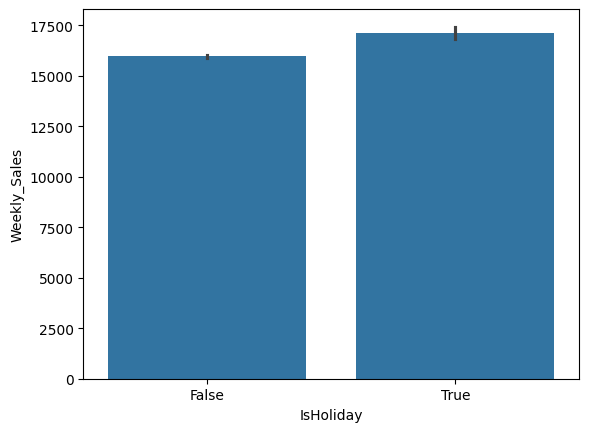

In [38]:
sns.barplot(x='IsHoliday', y='Weekly_Sales', data=df)

In [39]:
df_holiday = df.loc[df['IsHoliday']==True]
df_holiday['Date'].unique()

array(['2010-02-12', '2010-09-10', '2010-11-26', '2010-12-31',
       '2011-02-11', '2011-09-09', '2011-11-25', '2011-12-30',
       '2012-02-10', '2012-09-07'], dtype=object)

Some of the holidays are missing here. They are available in test dataset. I've inlcuded all the holidays for better understanding.

In [48]:
holiday_dates = {
    'Super_Bowl': ['2010-02-12', '2011-02-11', '2012-02-10'],
    'Labor_Day': ['2010-09-10', '2011-09-09', '2012-09-07'],
    'Thanksgiving': ['2010-11-26', '2011-11-25'],
    'Christmas': ['2010-12-31', '2011-12-30']
}

In [49]:
for holiday, dates in holiday_dates.items():
    df[holiday] = df['Date'].isin(dates)

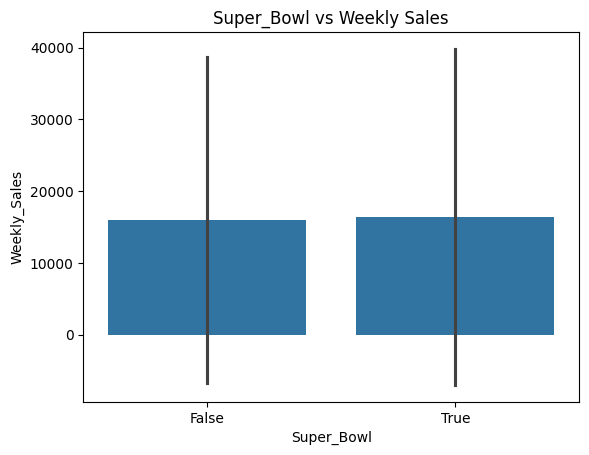

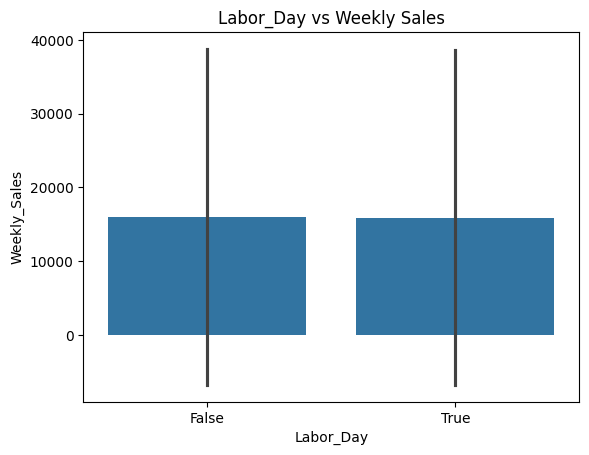

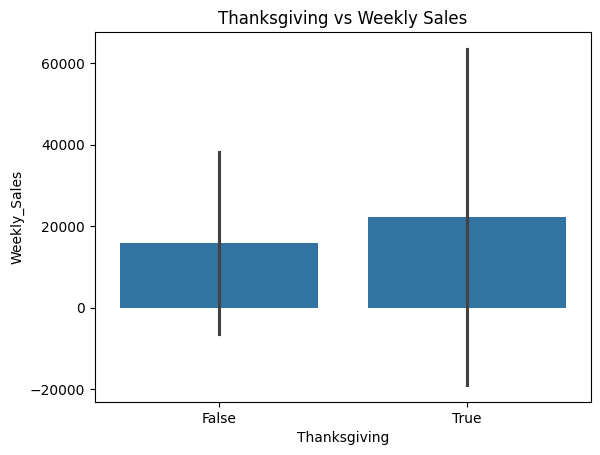

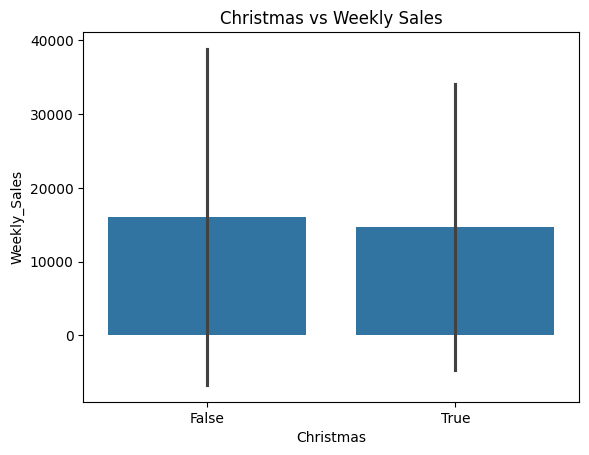

In [51]:
for holiday in holiday_dates.keys():
    plt.figure()  # start a new figure
    sns.barplot(x=holiday, y='Weekly_Sales', data=df, ci='sd')
    plt.title(f'{holiday} vs Weekly Sales')
    plt.show()

### Observations:

Christmas, Superbowl and Labor Day do not have a significant positive impact on the weekly sales. Whereas there is a significant increase in the sales during the thanksgiving holiday. This may be due to the facts that black Friday sales run during this time and people would buy gifts and Christmas decor during this time.

In [52]:
df.groupby(['Christmas','Type'])['Weekly_Sales'].mean()  # Avg weekly sales for types on Christmas

Christmas  Type
False      A       20174.350209
           B       12301.986116
           C        9570.951973
True       A       18310.167535
           B       11488.988057
           C        8031.520607
Name: Weekly_Sales, dtype: float64

In [54]:
df.groupby(['Labor_Day','Type'])['Weekly_Sales'].mean()  # Avg weekly sales for types on Labor Day

Labor_Day  Type
False      A       20151.210941
           B       12294.954138
           C        9542.098293
True       A       20004.267422
           B       12084.304642
           C        9893.459258
Name: Weekly_Sales, dtype: float64

In [55]:
df.groupby(['Thanksgiving','Type'])['Weekly_Sales'].mean()  # Avg weekly sales for types on Thanksgiving

Thanksgiving  Type
False         A       20044.007801
              B       12197.717405
              C        9547.377807
True          A       27397.776346
              B       18733.973971
              C        9696.566616
Name: Weekly_Sales, dtype: float64

In [56]:
df.groupby(['Super_Bowl','Type'])['Weekly_Sales'].mean()  # Avg weekly sales for types on Super Bowl

Super_Bowl  Type
False       A       20138.055908
            B       12286.739293
            C        9536.110508
True        A       20612.757674
            B       12467.035506
            C       10179.271884
Name: Weekly_Sales, dtype: float64

In [62]:
# Count how many of each type
type_counts = df['Type'].value_counts()  # gives a Series: index=Type, values=counts
print(type_counts)

Type
A    214961
B    162787
C     42464
Name: count, dtype: int64


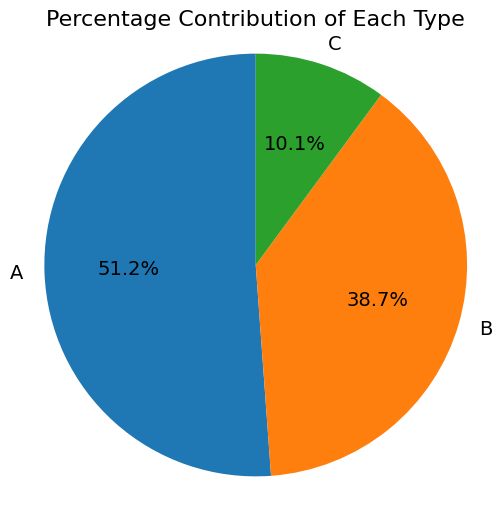

In [61]:
# Count how many of each type
type_counts = df['Type'].value_counts()  # gives a Series: index=Type, values=counts

# Convert counts to percentages
type_percent = type_counts / type_counts.sum() * 100

# Plot pie chart
plt.figure(figsize=(6,6))
plt.pie(
    type_percent, 
    labels=type_percent.index,       # Type names
    autopct='%1.1f%%',               # Show percentage on slices
    startangle=90,                    # Rotate chart so first slice starts at 12 o'clock
    textprops={'fontsize': 14}       # Bigger text
)
plt.axis('equal')                     # Make pie chart circular
plt.title('Percentage Contribution of Each Type', fontsize=16)
plt.show()

More than half the stores belong to type A. And tyoe A stores have highest sales throughout the year.

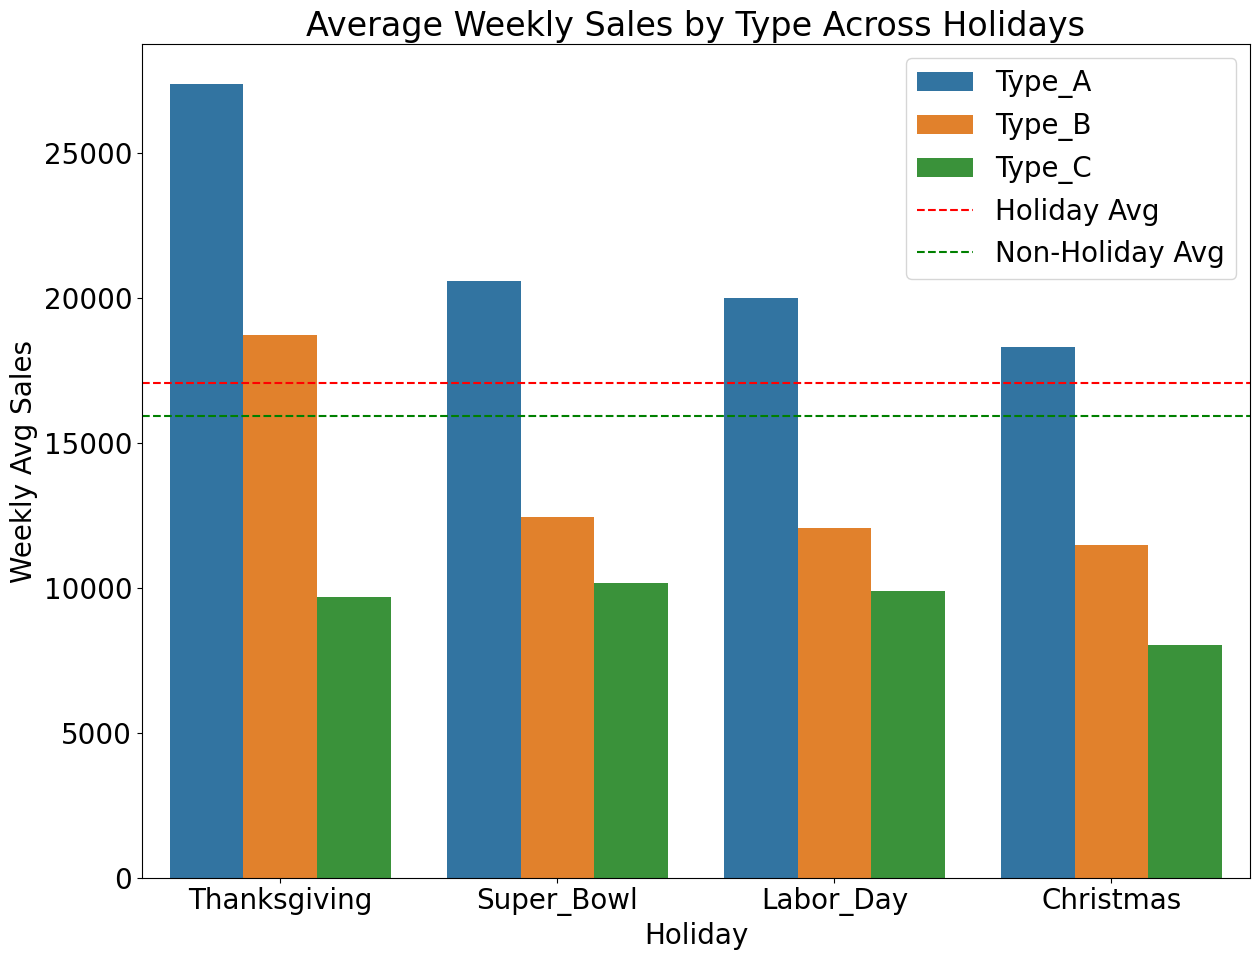

In [69]:
type_means = {
    'Type_A': [27397.77, 20612.75, 20004.26, 18310.16],
    'Type_B': [18733.97, 12463.41, 12080.75, 11483.97],
    'Type_C': [9696.56, 10179.27, 9893.45, 8031.52]
}
holidays = ['Thanksgiving', 'Super_Bowl', 'Labor_Day', 'Christmas']

# Convert to long-form DataFrame for seaborn
df_means = pd.DataFrame(type_means, index=holidays).reset_index()
df_melted = df_means.melt(id_vars='index', var_name='Type', value_name='Weekly_Avg_Sales')
df_melted.rename(columns={'index': 'Holiday'}, inplace=True)

# Plot grouped bar chart
plt.figure(figsize=(13,10))
sns.barplot(x='Holiday', y='Weekly_Avg_Sales', hue='Type', data=df_melted, ci=None)
plt.ylabel('Weekly Avg Sales')
plt.title('Average Weekly Sales by Type Across Holidays')
plt.axhline(y=17094.30, color='r', linestyle='--', label='Holiday Avg')
plt.axhline(y=15952.82, color='green', linestyle='--', label='Non-Holiday Avg')
plt.legend()
plt.tight_layout()
plt.show()

In [71]:
df.sort_values(by='Weekly_Sales',ascending=False).head(5)

,Store,Dept,Date,Weekly_Sales,Temperature_x,Fuel_Price_x,MarkDown1_x,MarkDown2_x,MarkDown3_x,MarkDown4_x,...,MarkDown5_y,CPI_y,Unemployment_y,IsHoliday,Type,Size,Super_Bowl,Labor_Day,Thanksgiving,Christmas
95373,10,72,2010-11-26,693099.36,55.33,3.162,NaN,NaN,NaN,NaN,...,NaN,126.669267,9.003,True,B,126512,False,False,True,False
338013,35,72,2011-11-25,649770.18,47.88,3.492,1333.24,NaN,58563.24,20.97,...,6386.86,140.421786,8.745,True,B,103681,False,False,True,False
95425,10,72,2011-11-25,630999.19,60.68,3.760,174.72,329.0,141630.61,79.00,...,1009.98,129.836400,7.874,True,B,126512,False,False,True,False
337961,35,72,2010-11-26,627962.93,46.67,3.039,NaN,NaN,NaN,NaN,...,NaN,136.689571,8.763,True,B,103681,False,False,True,False
135665,14,72,2010-11-26,474330.10,46.15,3.039,NaN,NaN,NaN,NaN,...,NaN,182.783277,8.724,True,A,200898,False,False,True,False


Top 5 weekly sales also belong to Thanksgiving week.

### Markdown Columns
Walmart gave markdown columns to see the effect if markdowns on sales. There are multiple NaN's for these columns. There is numerical data for some rows for this field. Hence it might be worthwhile to convert NaN's to 0 for consistency.

In [74]:
df.isna().sum()

Store                  0
Dept                   0
Date                   0
Weekly_Sales           0
Temperature_x          0
Fuel_Price_x           0
MarkDown1_x       270031
MarkDown2_x       309308
MarkDown3_x       283561
MarkDown4_x       285694
MarkDown5_x       269283
CPI_x                  0
Unemployment_x         0
Temperature_y          0
Fuel_Price_y           0
MarkDown1_y       270031
MarkDown2_y       309308
MarkDown3_y       283561
MarkDown4_y       285694
MarkDown5_y       269283
CPI_y                  0
Unemployment_y         0
IsHoliday              0
Type                   0
Size                   0
Super_Bowl             0
Labor_Day              0
Thanksgiving           0
Christmas              0
dtype: int64

In [75]:
df = df.fillna(0)

In [76]:
df.isna().sum() # last null check

Store             0
Dept              0
Date              0
Weekly_Sales      0
Temperature_x     0
Fuel_Price_x      0
MarkDown1_x       0
MarkDown2_x       0
MarkDown3_x       0
MarkDown4_x       0
MarkDown5_x       0
CPI_x             0
Unemployment_x    0
Temperature_y     0
Fuel_Price_y      0
MarkDown1_y       0
MarkDown2_y       0
MarkDown3_y       0
MarkDown4_y       0
MarkDown5_y       0
CPI_y             0
Unemployment_y    0
IsHoliday         0
Type              0
Size              0
Super_Bowl        0
Labor_Day         0
Thanksgiving      0
Christmas         0
dtype: int64

In [78]:
df.drop(columns = (['MarkDown1_y','MarkDown2_y', 'MarkDown3_y', 'MarkDown4_y', 'MarkDown5_y']) , axis=1,inplace=True) # to see weird statistical things

In [79]:
df.describe()

,Store,Dept,Weekly_Sales,Temperature_x,Fuel_Price_x,MarkDown1_x,MarkDown2_x,MarkDown3_x,MarkDown4_x,MarkDown5_x,CPI_x,Unemployment_x,Temperature_y,Fuel_Price_y,CPI_y,Unemployment_y,Size
count,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000
mean,22.195611,44.241309,16033.114591,60.090599,3.360890,2590.323565,878.905242,468.845949,1083.534361,1662.805002,171.212496,7.960000,60.090599,3.360890,171.212496,7.960000,136749.732787
std,12.787236,30.508819,22729.492116,18.447857,0.458519,6053.415601,5076.928566,5534.069859,3896.068938,4206.209357,39.162445,1.863879,18.447857,0.458519,39.162445,1.863879,60993.084568
min,1.000000,1.000000,0.010000,-2.060000,2.472000,0.000000,-265.760000,-29.100000,0.000000,0.000000,126.064000,3.879000,-2.060000,2.472000,126.064000,3.879000,34875.000000
25%,11.000000,18.000000,2120.130000,46.680000,2.933000,0.000000,0.000000,0.000000,0.000000,0.000000,132.022667,6.891000,46.680000,2.933000,132.022667,6.891000,93638.000000
50%,22.000000,37.000000,7661.700000,62.090000,3.452000,0.000000,0.000000,0.000000,0.000000,0.000000,182.350989,7.866000,62.090000,3.452000,182.350989,7.866000,140167.000000
75%,33.000000,74.000000,20271.265000,74.280000,3.738000,2809.050000,2.400000,4.540000,425.290000,2168.040000,212.445487,8.567000,74.280000,3.738000,212.445487,8.567000,202505.000000
max,45.000000,99.000000,693099.360000,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000,100.140000,4.468000,227.232807,14.313000,219622.000000


One thing to notice here is that minimum weekly sales value is 0.01 which is likely not true.

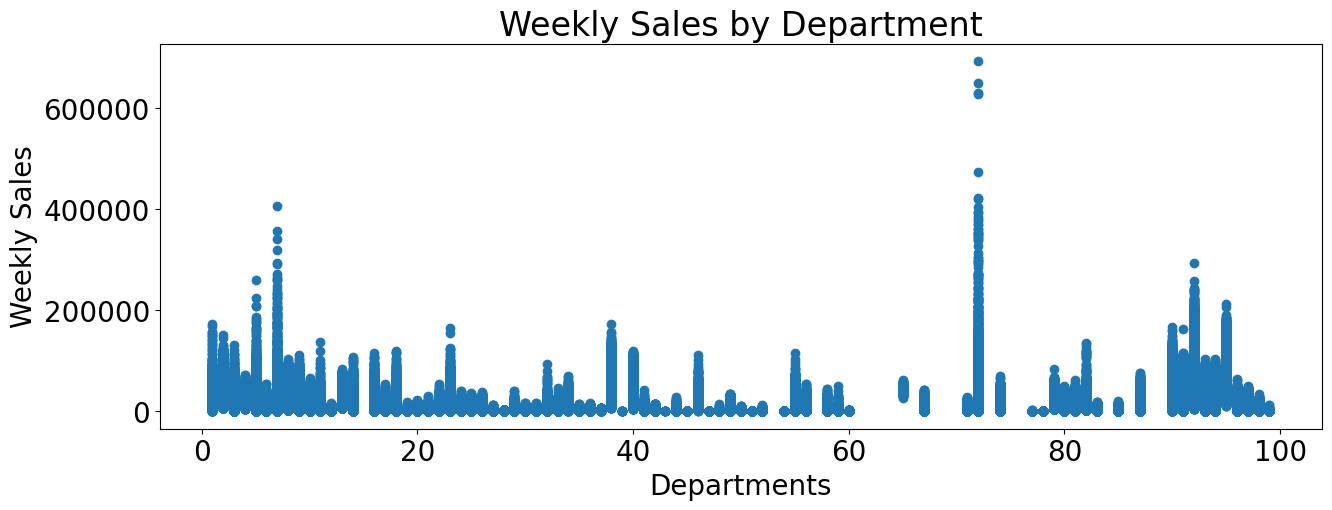

In [80]:
x = df['Dept']
y = df['Weekly_Sales']
plt.figure(figsize=(15,5))
plt.title('Weekly Sales by Department')
plt.xlabel('Departments')
plt.ylabel('Weekly Sales')
plt.scatter(x,y)
plt.show()

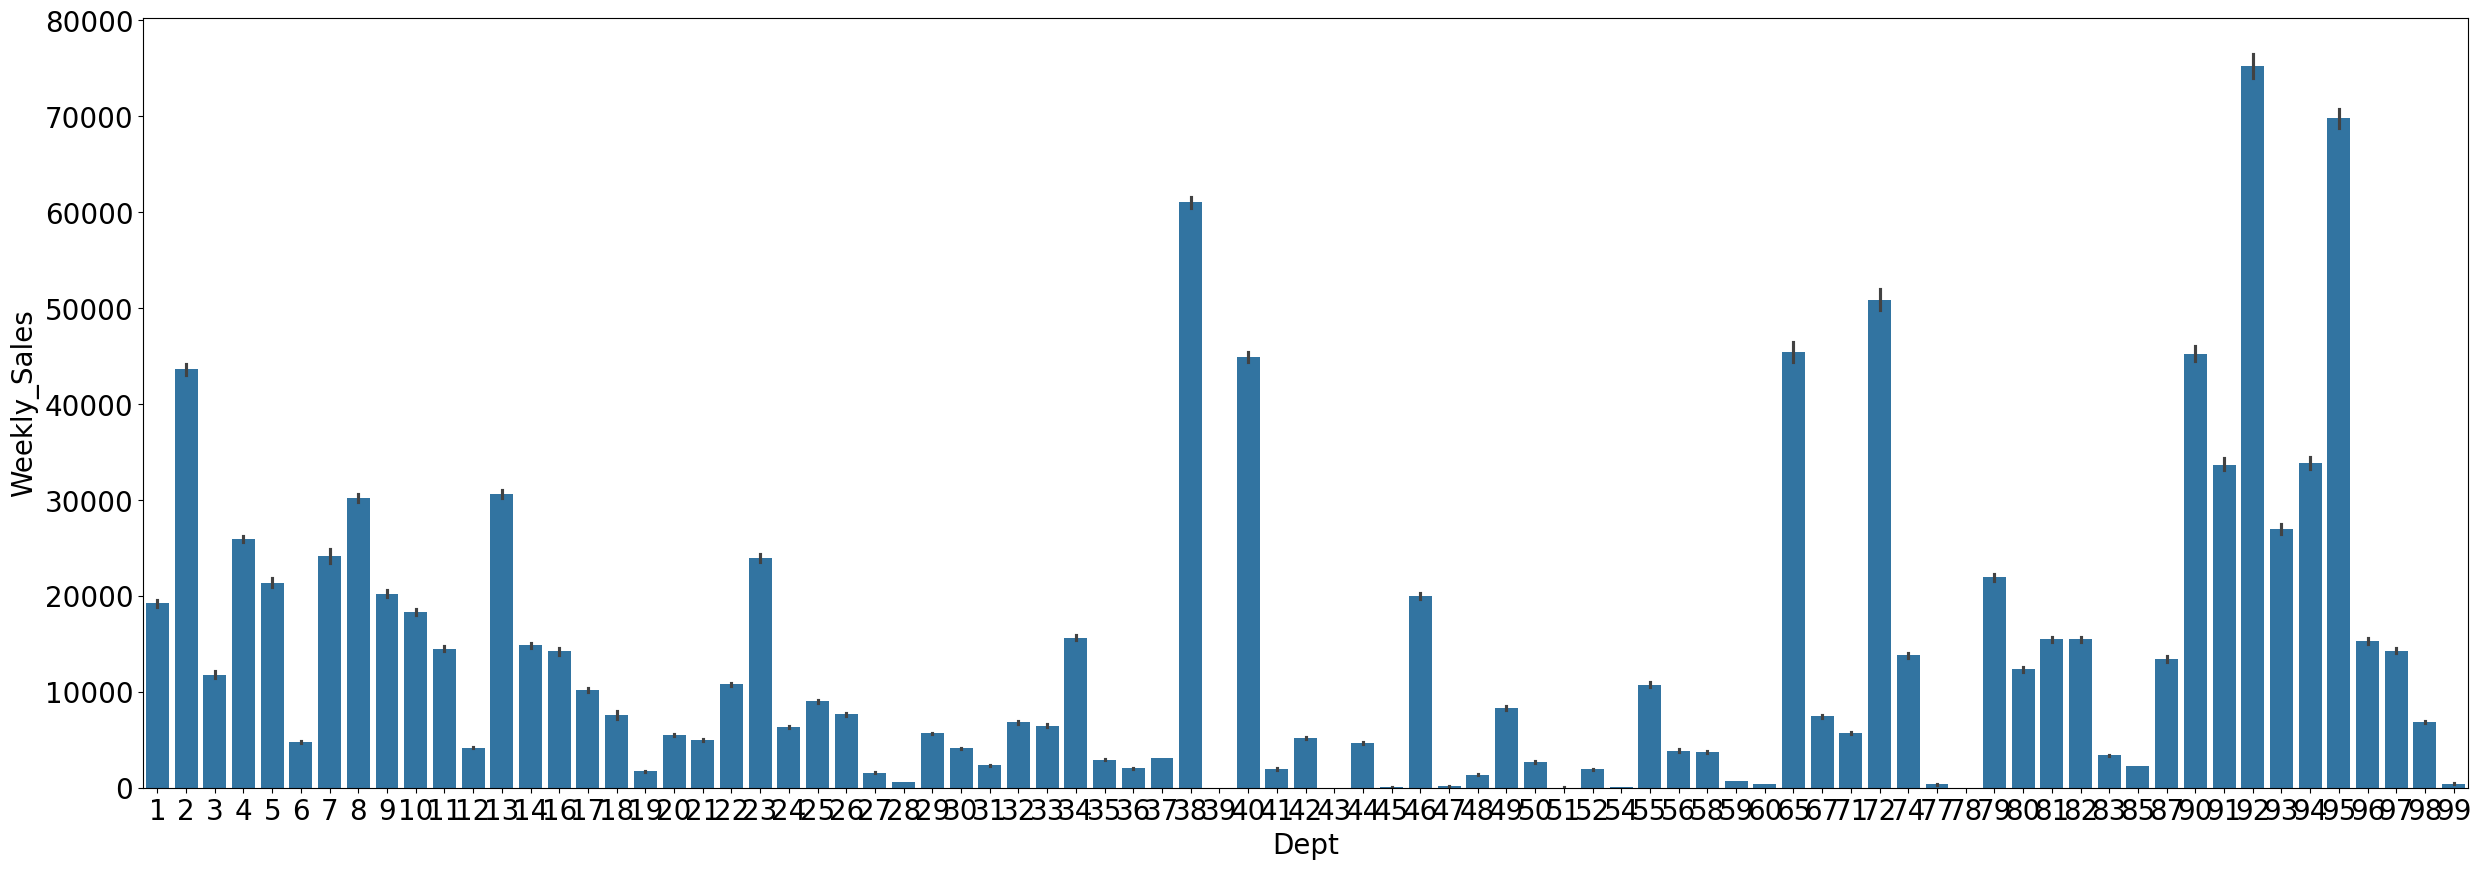

In [81]:
plt.figure(figsize=(30,10))
fig = sns.barplot(x='Dept', y='Weekly_Sales', data=df)

The scatter plot shows that there is higher sales associated for a certain department between 60 - 80. Whereas, average weekly sales bar plot shows that dept 92 has the highest avg weekly sales. This indicates that there might be seasonal variations.

### TimeFrame related Analysis

In [83]:
df["Date"] = pd.to_datetime(df["Date"]) # convert to datetime
df['week'] =df['Date'].dt.isocalendar().week
df['month'] =df['Date'].dt.month
df['year'] =df['Date'].dt.year

In [84]:
df.groupby('month')['Weekly_Sales'].mean() # to see the best months for sales

month
1     14182.239153
2     16048.701191
3     15464.817698
4     15696.435193
5     15845.556200
6     16397.605478
7     15905.472425
8     16113.800069
9     15147.216063
10    15279.182119
11    17534.964277
12    19425.798603
Name: Weekly_Sales, dtype: float64

In [85]:
df.groupby('year')['Weekly_Sales'].mean() # to see the best years for sales

year
2010    16318.648285
2011    16007.797985
2012    15748.265005
Name: Weekly_Sales, dtype: float64

<Axes: xlabel='month'>

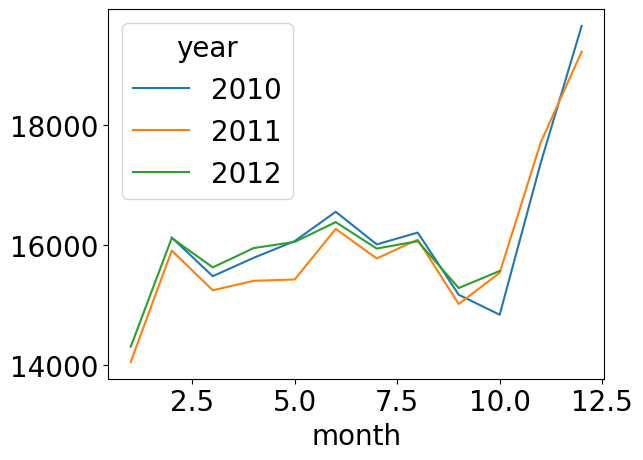

In [86]:
monthly_sales = pd.pivot_table(df, values = "Weekly_Sales", columns = "year", index = "month")
monthly_sales.plot()

Based on the graph, 2011 has lower sales as compared to 2010 and 2012. Though the data for last 2 months of 2012 is missing, 2012 sales is still comparable to that of 2010.

In [87]:
df.groupby('week')['Weekly_Sales'].mean().sort_values(ascending=False).head()

week
51    26454.164116
47    22269.601768
50    20478.421134
49    18731.794840
22    16856.650245
Name: Weekly_Sales, dtype: float64

Top 5 sales averages by weekly belongs to 1-2 weeks before Christmas, Thanksgiving, Black Friday and end of May, when the schools are closed.

<Axes: xlabel='week'>

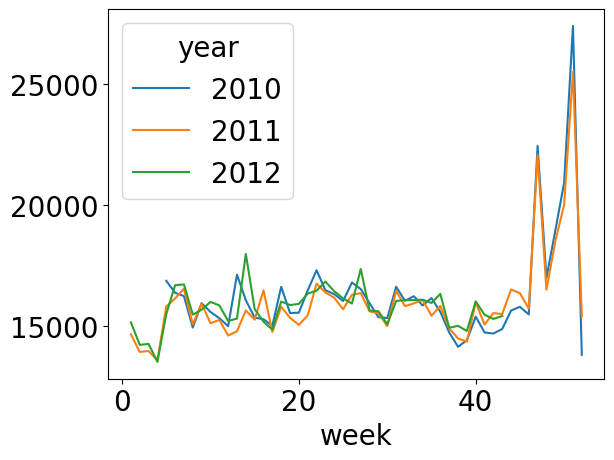

In [88]:
weekly_sales = pd.pivot_table(df, values = "Weekly_Sales", columns = "year", index = "week")
weekly_sales.plot()

## Explorations and Findings

* There are 45 stores and 81 department in data. Departments are not same in all stores.
* Although department 72 has higher weekly sales values, on average department 92 is the best. It shows us, some departments has higher values as seasonal like Thanksgiving. It is consistant when we look at the top 5 sales in data, all of them belongs to 72th department at Thanksgiving holiday time.
* Although stores 10 and 35 have higher weekly sales values sometimes, in general average store 20 and store 4 are on the first and second rank. It means that some areas has higher seasonal sales.
* Stores has 3 types as A, B and C according to their sizes. Almost half of the stores are bigger than 150000 and categorized as A. According to type, sales of the stores are changing.
* As expected, holiday average sales are higher than normal dates.
* Christmas holiday introduces as the last days of the year. But people generally shop at 51th week. So, when we look at the total sales of holidays, Thankgiving has higher sales between them which was assigned by Walmart.
* Year 2010 has higher sales than 2011 and 2012. But, November and December sales are not in the data for 2012. Even without highest sale months, 2012 is not significantly less than 2010, so after adding last two months, it can be first.
* It is obviously seen that week 51 and 47 have higher values and 50-48 weeks follow them. Interestingly, 5th top sales belongs to 22th week of the year. This results show that Christmas, Thankgiving and Black Friday are very important than other weeks for sales and 5th important time is 22th week of the year and it is end of the May, when schools are closed. Most probably, people are preparing for holiday at the end of the May.
* January sales are significantly less than other months. This is the result of November and December high sales. After two high sales month, people prefer to pay less on January.

## Feature Engineering

In [110]:
# Feature Engineering: Date features, categorical encoding, interaction features
df_fe = df.copy()

# Date features
df_fe['Date'] = pd.to_datetime(df_fe['Date'])
df_fe['year'] = df_fe['Date'].dt.year
df_fe['month'] = df_fe['Date'].dt.month
df_fe['week'] = df_fe['Date'].dt.isocalendar().week
df_fe['dayofweek'] = df_fe['Date'].dt.dayofweek
df_fe['is_month_start'] = df_fe['Date'].dt.is_month_start.astype(int)
df_fe['is_month_end'] = df_fe['Date'].dt.is_month_end.astype(int)

# Encode Store Type
df_fe = pd.get_dummies(df_fe, columns=['Type'], drop_first=False)

df_fe.head()



,Store,Dept,Date,Weekly_Sales,Temperature_x,Fuel_Price_x,MarkDown1_x,MarkDown2_x,MarkDown3_x,MarkDown4_x,...,Christmas,week,month,year,dayofweek,is_month_start,is_month_end,Type_A,Type_B,Type_C
0,1,1,2010-02-05,24924.50,42.31,2.572,0.0,0.0,0.0,0.0,...,False,5,2,2010,4,0,0,True,False,False
1,1,1,2010-02-12,46039.49,38.51,2.548,0.0,0.0,0.0,0.0,...,False,6,2,2010,4,0,0,True,False,False
2,1,1,2010-02-19,41595.55,39.93,2.514,0.0,0.0,0.0,0.0,...,False,7,2,2010,4,0,0,True,False,False
3,1,1,2010-02-26,19403.54,46.63,2.561,0.0,0.0,0.0,0.0,...,False,8,2,2010,4,0,0,True,False,False
4,1,1,2010-03-05,21827.90,46.50,2.625,0.0,0.0,0.0,0.0,...,False,9,3,2010,4,0,0,True,False,False


In [111]:
# Encode holidays as binary
for col in ['Super_Bowl', 'Labor_Day', 'Thanksgiving', 'Christmas']:
    if df_fe[col].dtype == 'bool':
        df_fe[col] = df_fe[col].astype(int)

# Interaction feature: Store Size x CPI
if 'Size' in df_fe.columns and 'CPI' in df_fe.columns:
    df_fe['Size_CPI'] = df_fe['Size'] * df_fe['CPI']

# Lag feature (previous week's sales)
df_fe['Weekly_Sales_lag1'] = df_fe.groupby(['Store','Dept'])['Weekly_Sales'].shift(1)
df_fe['Weekly_Sales_lag2'] = df_fe.groupby(['Store','Dept'])['Weekly_Sales'].shift(2)

In [112]:
print(df_fe.columns)

Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'Temperature_x',
       'Fuel_Price_x', 'MarkDown1_x', 'MarkDown2_x', 'MarkDown3_x',
       'MarkDown4_x', 'MarkDown5_x', 'CPI_x', 'Unemployment_x',
       'Temperature_y', 'Fuel_Price_y', 'CPI_y', 'Unemployment_y', 'IsHoliday',
       'Size', 'Super_Bowl', 'Labor_Day', 'Thanksgiving', 'Christmas', 'week',
       'month', 'year', 'dayofweek', 'is_month_start', 'is_month_end',
       'Type_A', 'Type_B', 'Type_C', 'Weekly_Sales_lag1', 'Weekly_Sales_lag2'],
      dtype='object')


In [115]:
# Drop rows with missing lag features (for modeling)
df_model = df_fe.dropna(subset=['Weekly_Sales_lag1', 'Weekly_Sales_lag2'])

In [116]:
# Features for modeling (excluding target and identifiers)
feature_cols = [col for col in df_model.columns if col not in [
    'Weekly_Sales', 'Date', 'Store', 'Dept'] and not col.startswith('Weekly_Sales_lag')]
feature_cols += ['Weekly_Sales_lag1', 'Weekly_Sales_lag2']

X = df_model[feature_cols]
y = df_model['Weekly_Sales']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [117]:
# Train Linear Regression model
lr = LinearRegression()
lr.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [118]:
# Predict and evaluate
y_pred = lr.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Linear Regression MSE: {mse:.2f}")
print(f"Linear Regression R^2: {r2:.4f}")

Linear Regression MSE: 37446994.92
Linear Regression R^2: 0.9264


### Interpreting Model Metrics: MSE and R²
- **Mean Squared Error (MSE)** measures the average squared difference between the actual weekly sales and the predicted sales. A lower MSE means the predictions are closer to the true values. In this case, the MSE is large because weekly sales values are large numbers.
- **R² (Coefficient of Determination)** shows how well the model explains the variance in weekly sales. An R² of 0.9264 means the model explains about 92.6% of the variation in sales.

**Summary:**
- The linear regression model fits the data well and makes accurate predictions.
- Accuracy can be further improved, by trying more advanced models or additional feature engineering.